## Determining whether a bean leaf is healthy or not using image classification machine learning model

- Source: https://huggingface.co/blog/fine-tune-vit
- The goal of this fine tuning project is to train our beans image dataset available on huggingface, so that our fine tuned model makes prediction for a given bean-leaf image by determining if the leaf is healthy or unhealthy. I used transformers library to use google's vit-base-patch16-224-in21k model.

## Our model has three sections:
- Loading data and pre-processing it
- Using our vit-base-patch16-224-in21k to train our model on the dataset
- Evaluating accuracy
  The beans dataset from huggingface already comes with train, test, and validation sets

## Loading our data
- Here, we are importing load_dataset from datasets library

In [ ]:
! pip install transformers datasets; ## If, in case, the model is being runned on a different device in which transformers in not available.

In [3]:
from datasets import load_dataset
ds = load_dataset('beans')
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

## We visually check the 400th image to see if our dataset has loaded properly

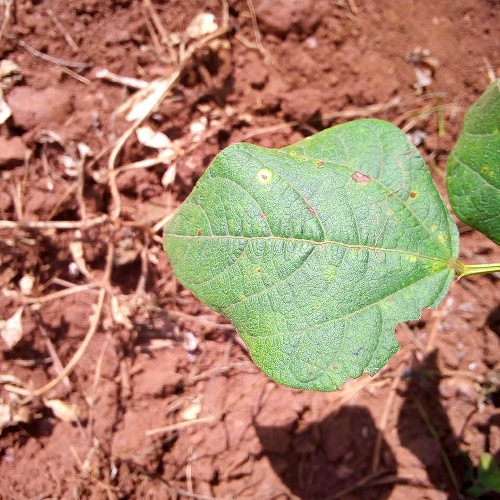

In [5]:
ex = ds['train'][400]
ex['image']

## We will confirm that our labels have been loaded properly

In [6]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

- Converting int label to string label

In [7]:
labels.int2str(ex['labels'])


'bean_rust'

## Producing a random plot of a few images

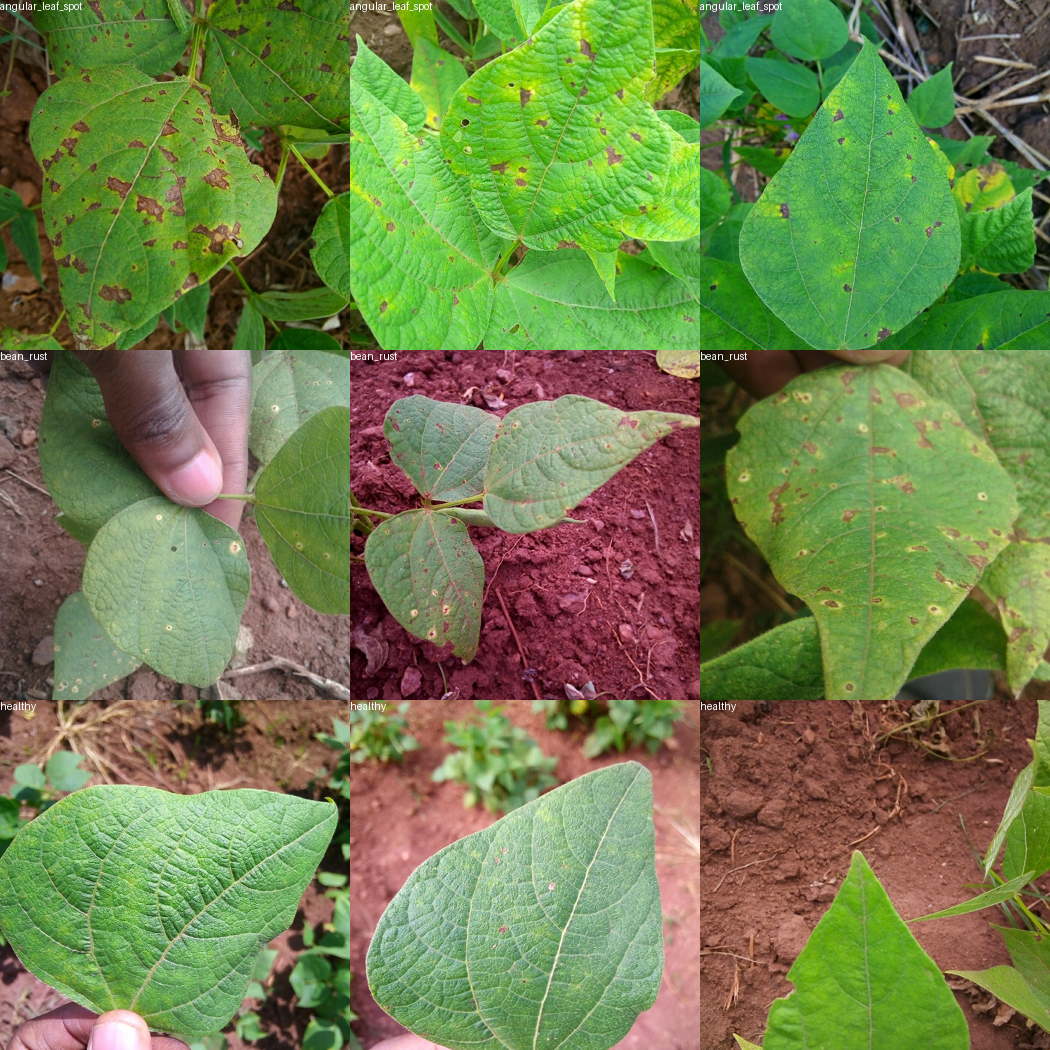

In [8]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    #font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Importing the model
- When ViT models are trained a specific set of operations are applied and we need to ensure that we follow same tranformations to feed our images into the network. Google uses ViTImageProcessor. Therefore, we need to ensure that we use same processor. We can import ViTImageProcessor from transformers library.
  
Citation: https://huggingface.co/blog/fine-tune-vit#:~:text=To%20make%20sure,Hugging%20Face%20Hub.

In [25]:
from transformers import ViTImageProcessor ##importing ViTImageProcessor from transformers

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)


## Pre-processing our images
- The following method takes an image and converts it into tensors and returns it. This method is called by transform(example_batch) which takes all images from a mini-batch and sends them to process_example(example) method.

In [11]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs


- As mentioned earlier, tranform(example_batch) take images from a mini-batch and sends them to process_example(example) one by one. Once process_example returns tensors of a given image, it stores them inside inputs list.

In [26]:
ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to tensors
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # we are adding labels to our inputs list data. 
    inputs['labels'] = example_batch['labels']
    return inputs


In [15]:
prepared_ds = ds.with_transform(transform)


## Here we are creating a collate function. The reason for using collate_fn is to stack all tensors of every image in a given batch into one variable called 'pixel_values'. This function also stacks all labels into one variable called 'labels'. 

In [27]:
import torch

## Stacks all tensor values(pixels) and labels of all images in a given batch into two variables
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## We define a compute metric to compare our training results with the actual results.
- The metric.compute function takes a prediction and compares it with actual result. This method will be used while we evaluate our training datasets

In [17]:
import numpy as np
from datasets import load_metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_812/311509507.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


- Here we import ViTForImageClassification from tranformers library. We will use ViTForImageClassification for image classification

In [18]:
from transformers import ViTForImageClassification
labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- mlFlow is a framework that supports the machine learning lifecycle. It has components that we can use to monitor our model during training and running. It is also capable of storing models, loading model in production code, and creating a pipeline. This was already installed on my account, but if the same code is being runned by some other user, then to ensure that they don't get any error, I am adding this code line.

In [4]:
pip install mlflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Now we will create training arguments for our model

- We are setting up our training arguments in the code below. Output_dir is the directors that we want to output our models results into.
- The per_device_train_batch_size the number of batches of data that we want to interate over for every epoch.
- We are setting evaluation strategy to steps and running four epochs.
- Evaluation strategy is a measure that we use. Once we set evalutation_strategy="steps", we have to tell the model in terms of steps such as save_steps, log_steps, and eval_steps.
- fp16=True indicates that we are enabling 16-bit floating point. Usually, In machine learning, we perform computation on 32-bit floating point, but 16-bit floating point can speed up computations.
 https://medium.com/@furkangozukara/what-is-the-difference-between-fp16-and-bf16-here-a-good-explanation-for-you-d75ac7ec30fa#:~:text=FP16%20is%20commonly%20used%20in%20deep%20learning%20training%20and%20inference%20due%20to%20its%20ability%20to%20accelerate%20computations%20by%20performing%20more%20calculations%20per%20unit%20time.
- save_steps = 100, every 100 steps we are saving our results in the output_dir
-  eval_steps=100, every 100 steps we are evaulating our model accuracy
-  logging_steps=10, we output or display our validation loss, training loss, or accuracy
-  learning_rate=2e-4 indicates that we are setting our model's learning rate to 2e-4
-  save_total_limit = 2 indicates that we are saving only two logs of our model at the most. Logs in this context is our accruacy and losses for every 100 steps 
-  remove_unused_columns=False is a very important attribute. Usually we set this to True, which means we drop any unused columns from our dataset during training process. But in our case, since we have only two columns and both columns are in use: labels and also images. We do not drop anything column during training
-  push_to_hub = False will ensure that we are not pushing our model into huggigface respository. However, our model will be saved in output_dir without any issues
-  report_to='mlflow' meas that we are setting our training artchitecture/framework to mlflow
-  load_best_model_at_end=True, means we will load the best model as our checkpoint that we have so far

In [19]:
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='mlflow',
  load_best_model_at_end=True,
)

- In the method below, we are creating our training model
- args = training_args indicate that we are inputing training arguments into our arguments
- We then use data_collator() to collate and image tensors and y-labels into two lists.
- We use compute_metrics methods that we created above
- We then feed our training and validation datasets into our model
- We are using processor method that we created above to tokenize our images

In [20]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

## Evaluating our model
- Below, we evaluate our model and use log_metrics and save_metrics to save and log our results

In [21]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


Step,Training Loss,Validation Loss,Accuracy
100,0.070200,0.147313,0.962406
200,0.040700,0.047149,0.977444


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1079
  train_runtime            =  0:06:54.15
  train_samples_per_second =       9.987
  train_steps_per_second   =       0.628


## At the end, we are evaluating our model on the validation dataset
- Accuracy = 99.25%

In [131]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0206
  eval_runtime            = 0:00:02.83
  eval_samples_per_second =      46.86
  eval_steps_per_second   =       5.99
